In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
df = pd.read_csv('us-states.csv')

In [3]:
# Sort to choose which states to consider
# df.groupby(['state']).sum().sort_values(by=['deaths'])

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

In [4]:
California = df[df['state']=='California']
NewYork = df[df['state']=='New York']
Texas = df[df['state']=='Texas']

Virginia = df[df['state']=='Virginia']

NorthernMarianaIslands = df[df['state']=='Northern Mariana Islands']
VirginIslands= df[df['state']=='Virgin Islands']
Guam= df[df['state']=='Guam']

# Preprocessing Data

In [5]:
state = 'NY'
cases_deaths  = NewYork[['cases','deaths']].to_numpy()
cases_deaths[:,0]= cumulative_to_daily(cases_deaths[:,0])
cases_deaths[:,1]= cumulative_to_daily(cases_deaths[:,1])

scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
cases_deaths = scaler.fit_transform(cases_deaths)

In [44]:
scaler.data_max_

array([20184.,  1036.])

In [6]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [7]:
cases_deaths=cases_deaths[13:] # Skip the first days where there's no data

In [8]:
window_size = 40

X,Y = convert_to_slide_window(cases_deaths,window_size)
split = int(len(X) * 0.8)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Daily + Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Daily + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [36]:
TST_model = TimeSeriesTransformer(n_features=2,d_model=128, n_heads=4, n_hidden=128, n_layers=4 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}'.format(state)))

Epoch 1 Loss is 0.4781293958425522
Epoch 2 Loss is 0.2552104592323303
Epoch 3 Loss is 0.16332670748233796
Epoch 4 Loss is 0.12418248355388642
Epoch 5 Loss is 0.11766924634575844
Epoch 6 Loss is 0.14124149605631828
Epoch 7 Loss is 0.11905514150857925
Epoch 8 Loss is 0.11125962138175964
Epoch 9 Loss is 0.12680354043841363
Epoch 10 Loss is 0.10477527305483818
Epoch 11 Loss is 0.10180801227688789
Epoch 12 Loss is 0.10098175927996636
Epoch 13 Loss is 0.10950392559170723
Epoch 14 Loss is 0.1037532664835453
Epoch 15 Loss is 0.09464453160762787
Epoch 16 Loss is 0.10511391758918762
Epoch 17 Loss is 0.08773106448352337
Epoch 18 Loss is 0.0841300867497921
Epoch 19 Loss is 0.08754272386431694
Epoch 20 Loss is 0.07923664040863514
Epoch 21 Loss is 0.07796828262507915
Epoch 22 Loss is 0.07214796841144562
Epoch 23 Loss is 0.07486680336296558
Epoch 24 Loss is 0.07029513232409954
Epoch 25 Loss is 0.06419138796627522
Epoch 26 Loss is 0.05924240425229073
Epoch 27 Loss is 0.058485301584005354
Epoch 28 Loss

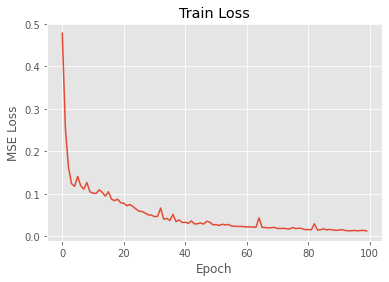

In [37]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [38]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print(predicted.shape)
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test).cpu().detach().numpy()

torch.Size([40, 73, 2])
TST: Test MSE Loss:  0.02680361457169056


In [39]:
X_train[-1].shape

torch.Size([40, 2])

In [40]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.1091, device='cuda:0', grad_fn=<MseLossBackward>)


In [41]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 398978 Parameters for the transformer model


In [42]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST)

In [43]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_TST[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_TST[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_TST[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_TST[:,1]))

R2 Score for Cases 0.9454065264899035
MAPE Score for Cases 0.1530901
R2 Score for Deaths 0.9576160902143346
MAPE Score for Deaths 0.36920816


# LSTM Model

In [45]:
LSTM_model = COVID_LSTM(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}'.format(state)))

Epoch 1 Loss is 0.6304917573928833
Epoch 2 Loss is 0.5620385468006134
Epoch 3 Loss is 0.5219121754169465
Epoch 4 Loss is 0.44458395540714263
Epoch 5 Loss is 0.34036271572113036
Epoch 6 Loss is 0.17272287011146545
Epoch 7 Loss is 0.16202937625348568
Epoch 8 Loss is 0.10632955580949784
Epoch 9 Loss is 0.10219556912779808
Epoch 10 Loss is 0.08327729515731334
Epoch 11 Loss is 0.09058896973729133
Epoch 12 Loss is 0.0689397320151329
Epoch 13 Loss is 0.066823086515069
Epoch 14 Loss is 0.05727419331669807
Epoch 15 Loss is 0.05240238327533007
Epoch 16 Loss is 0.07086879890412093
Epoch 17 Loss is 0.06514066010713578
Epoch 18 Loss is 0.04269198090769351
Epoch 19 Loss is 0.04146534418687224
Epoch 20 Loss is 0.06609462834894657
Epoch 21 Loss is 0.038889161217957734
Epoch 22 Loss is 0.04462443441152573
Epoch 23 Loss is 0.03606025762856006
Epoch 24 Loss is 0.035175243765115737
Epoch 25 Loss is 0.03253915833774954
Epoch 26 Loss is 0.03086061424110085
Epoch 27 Loss is 0.030235975701361894
Epoch 28 Loss

In [46]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test).cpu().detach().numpy()

LSTM: Test MSE Loss:  0.027334390208125114


In [47]:
X_test.shape

torch.Size([73, 40, 2])

In [48]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)


In [50]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM)

In [51]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_LSTM[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_LSTM[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_LSTM[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_LSTM[:,1]))

R2 Score for Cases 0.9934032368677419
MAPE Score for Cases 0.19946977
R2 Score for Deaths 0.37479514218723153
MAPE Score for Deaths 0.64838815


# GRU Model

In [52]:
GRU_model = COVID_GRU(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}'.format(state)))

Epoch 1 Loss is 0.6110749959945678
Epoch 2 Loss is 0.47764372527599336
Epoch 3 Loss is 0.3269522964954376
Epoch 4 Loss is 0.19849735647439956
Epoch 5 Loss is 0.12617638632655143
Epoch 6 Loss is 0.0954153373837471
Epoch 7 Loss is 0.09340561628341675
Epoch 8 Loss is 0.08034569025039673
Epoch 9 Loss is 0.07211888562887907
Epoch 10 Loss is 0.06452162452042103
Epoch 11 Loss is 0.05190293155610561
Epoch 12 Loss is 0.042199802584946156
Epoch 13 Loss is 0.03909952100366354
Epoch 14 Loss is 0.030873091146349906
Epoch 15 Loss is 0.03031183797866106
Epoch 16 Loss is 0.02870084550231695
Epoch 17 Loss is 0.030786853469908237
Epoch 18 Loss is 0.027817780151963234
Epoch 19 Loss is 0.02563358237966895
Epoch 20 Loss is 0.02475702576339245
Epoch 21 Loss is 0.024085352988913657
Epoch 22 Loss is 0.024653137661516666
Epoch 23 Loss is 0.023624134808778764
Epoch 24 Loss is 0.023404542356729507
Epoch 25 Loss is 0.02186005571857095
Epoch 26 Loss is 0.022371740080416203
Epoch 27 Loss is 0.021759957540780306
Epo

In [53]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test).cpu().detach().numpy()

GRU: Test MSE Loss:  0.0250916238874197


In [54]:
X_test.shape

torch.Size([73, 40, 2])

In [55]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0649, device='cuda:0', grad_fn=<MseLossBackward>)


In [56]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU)

In [57]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_GRU[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_GRU[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_GRU[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_GRU[:,1]))

R2 Score for Cases 0.9964465162940165
MAPE Score for Cases 0.17680365
R2 Score for Deaths 0.9261267024171135
MAPE Score for Deaths 0.41397455


# Plots

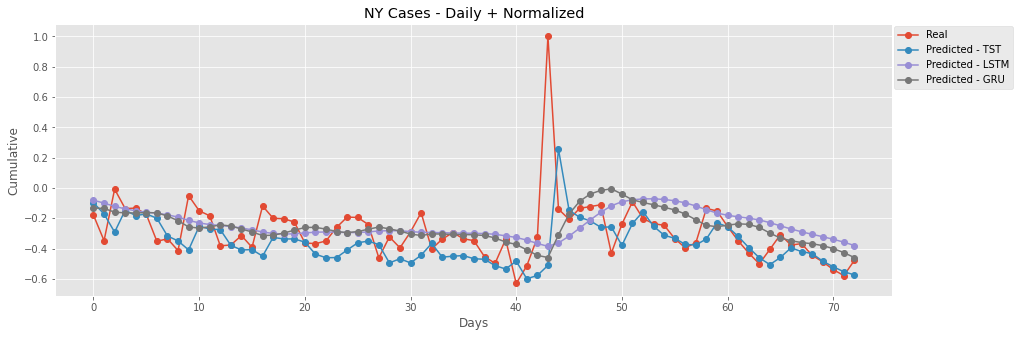

In [59]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

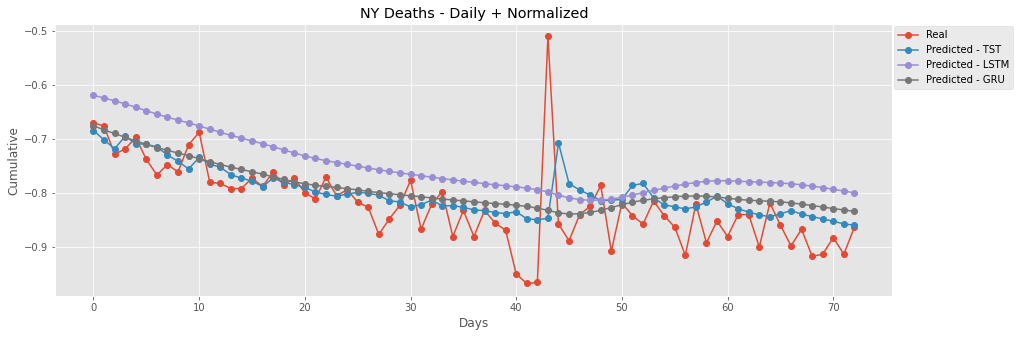

In [61]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,1].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,1],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,1].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

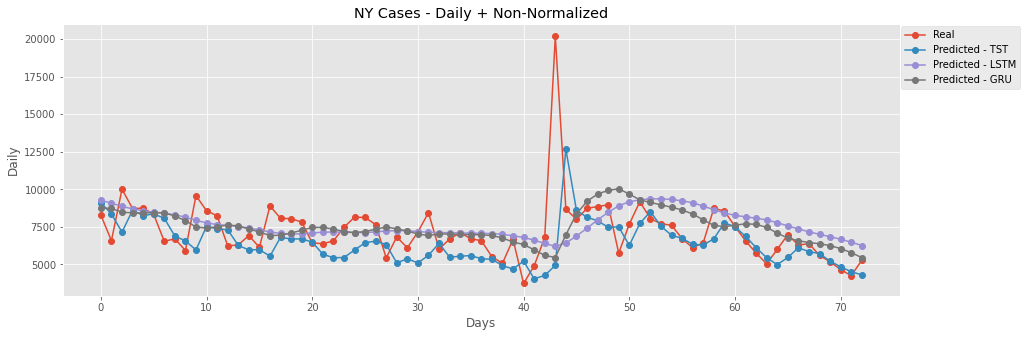

In [65]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

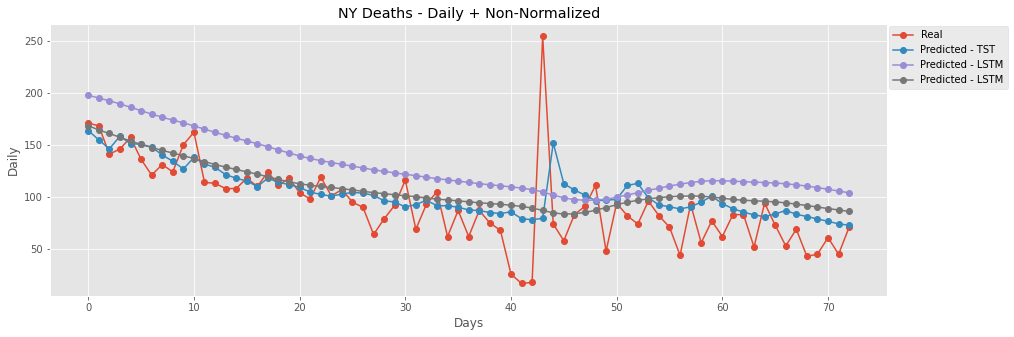

In [64]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,1],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,1],label='Predicted - LSTM',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()